In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa

In [5]:
wavs = [file for file in os.listdir('../../dataset/AudioWAV/')]
actors = pd.read_csv('../../dataset/VideoDemographics.csv')

In [6]:
genders = []
ages = []
emotions = []
emotion_levels = []
locations = []

for i, file_name, in enumerate(wavs):
    partition = wavs[i].split('_')
    location = '../../dataset/AudioWAV/' + file_name
    actor_id = partition[0]
    actor_info = actors.loc[actors['ActorID']==int(actor_id), ['Sex', 'Age']].values
    gender = actor_info[0][0]
    age = actor_info[0][1]
    emotion = partition[2]
    emotion_level = partition[3].split('.')[0]
    genders.append(gender)
    ages.append(age)
    emotions.append(emotion)
    emotion_levels.append(emotion_level)
    locations.append(location)

df = pd.DataFrame({'Gender':genders, 'Age':ages, 'Emotion':emotions, 'Emotion levels':emotion_levels, 'Location':locations})

In [7]:
df.head(10)

,Gender,Age,Emotion,Emotion levels,Location
0,Male,42,ANG,XX,../../dataset/AudioWAV/1041_IOM_ANG_XX.wav
1,Male,29,HAP,XX,../../dataset/AudioWAV/1005_ITH_HAP_XX.wav
2,Female,52,ANG,MD,../../dataset/AudioWAV/1056_IEO_ANG_MD.wav
3,Male,62,HAP,LO,../../dataset/AudioWAV/1087_IEO_HAP_LO.wav
4,Female,33,ANG,XX,../../dataset/AudioWAV/1052_MTI_ANG_XX.wav
5,Male,42,SAD,XX,../../dataset/AudioWAV/1017_DFA_SAD_XX.wav
6,Female,22,ANG,HI,../../dataset/AudioWAV/1046_IEO_ANG_HI.wav
7,Female,25,FEA,HI,../../dataset/AudioWAV/1049_IEO_FEA_HI.wav
8,Male,53,NEU,XX,../../dataset/AudioWAV/1064_MTI_NEU_XX.wav
9,Female,40,SAD,XX,../../dataset/AudioWAV/1075_ITH_SAD_XX.wav


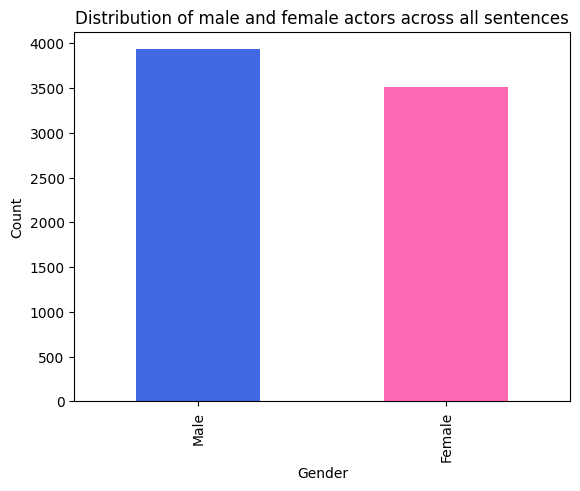

In [8]:
gender_counts = df['Gender'].value_counts()
colors = {'Male': 'royalblue', 'Female': 'hotpink'}
gender_counts.plot(kind='bar', color=[colors.get(gender, 'gray') for gender in gender_counts.index])
plt.ylabel('Count')
plt.title('Distribution of male and female actors across all sentences')
plt.show()

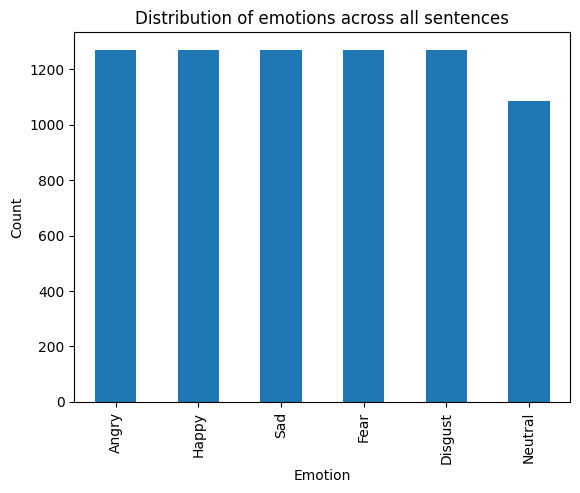

In [9]:
emotions_counts = df['Emotion'].value_counts()
emotion_mapping = {
    'ANG': 'Angry',
    'HAP': 'Happy',
    'SAD': 'Sad',
    'FEA': 'Fear',
    'DIS': 'Disgust',
    'NEU': 'Neutral'
}
emotions_counts = emotions_counts.rename(index=emotion_mapping)
emotions_counts.plot(kind='bar')
plt.ylabel('Count')
plt.title('Distribution of emotions across all sentences')
plt.show()

### Extracting acoustic features

In [10]:
# Mel-Frequency Cepstral Coefficients
def mfccs(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    return mfcc, mfcc_delta, mfcc_delta2

# Mel-Spectrogram
def mel_spec(y, sr):
    melspect = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(melspect, ref=np.max)
    return mel_spec_db

# Spectral Centroid
def spectral_centroid(y, sr):
    return librosa.feature.spectral_centroid(y=y, sr=sr)

# Zero Crossing Rate (ZCR)
def zero_crossings(y):
    return librosa.feature.zero_crossing_rate(y=y)

In [11]:
def extract_acoustic_features(y, sr):
    features = {}

    mfcc, mfcc_delta, mfcc_delta2 = mfccs(y=y, sr=sr)
    features['mfcc'] = mfcc
    features['mfcc_delta'] = mfcc_delta
    features['mfcc_delta2'] = mfcc_delta2

    features['mel_spec_db'] = mel_spec(y=y, sr=sr)

    features['spectral_centroid'] = spectral_centroid(y=y, sr=sr)

    features['zcr'] = zero_crossings(y=y)

    return features

def visualize_features(features, sr):
    plt.figure(figsize=(15, 10))
    
    # MFCCs
    plt.subplot(3, 1, 1)
    librosa.display.specshow(features['mfcc'], x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs')
    
    # MFCC Deltas (Δ)
    plt.subplot(3, 1, 2)
    librosa.display.specshow(features['mfcc_delta'], x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title('MFCC Δ (Velocity)')
    
    # MFCC Delta-Deltas (ΔΔ)
    plt.subplot(3, 1, 3)
    librosa.display.specshow(features['mfcc_delta2'], x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title('MFCC ΔΔ (Acceleration)')
    plt.tight_layout()
    plt.show()

    # Mel-Spectrogram (dB)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(features['mel_spec_db'], x_axis='time', y_axis='mel', sr=sr, cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram (dB)')
    plt.show()

    plt.figure(figsize=(12, 8))
    
    # Spectral Centroid
    plt.subplot(2, 1, 1)
    times = librosa.times_like(features['spectral_centroid'], sr=sr)
    plt.plot(times, features['spectral_centroid'].T, label='Spectral Centroid', color='b')
    plt.ylabel('Spectral Centroid (Hz)')
    plt.title('Spectral Centroid')
    
    # Zero Crossing Rate (ZCR)
    plt.subplot(2, 1, 2)
    plt.plot(times, features['zcr'].T, label='ZCR', color='r')
    plt.xlabel('Time (s)')
    plt.ylabel('ZCR')
    plt.title('Zero Crossing Rate')
    
    plt.tight_layout()
    plt.show()

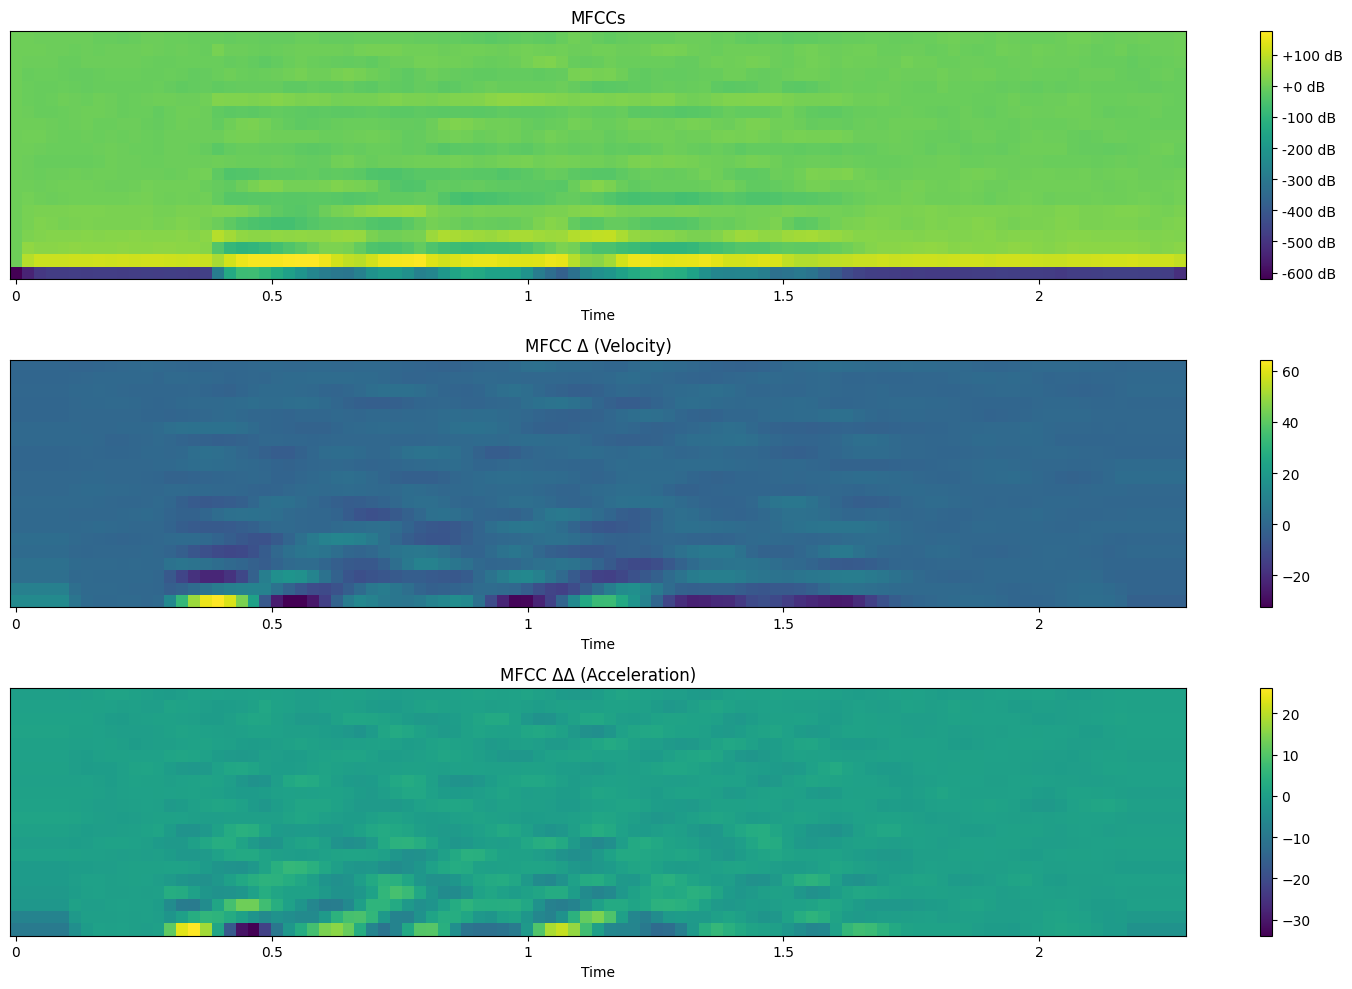

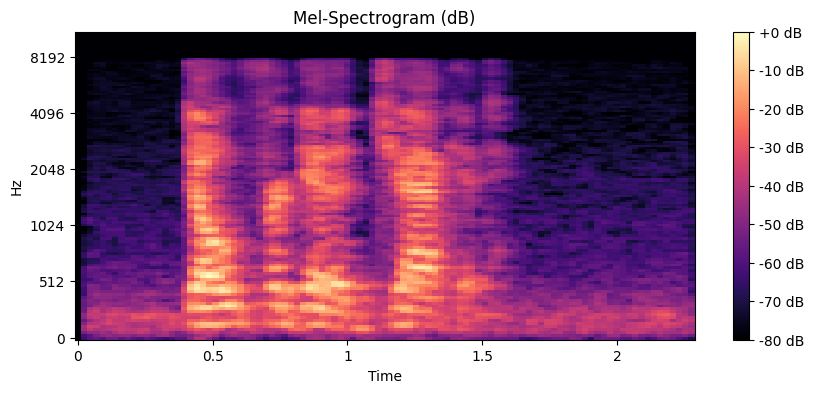

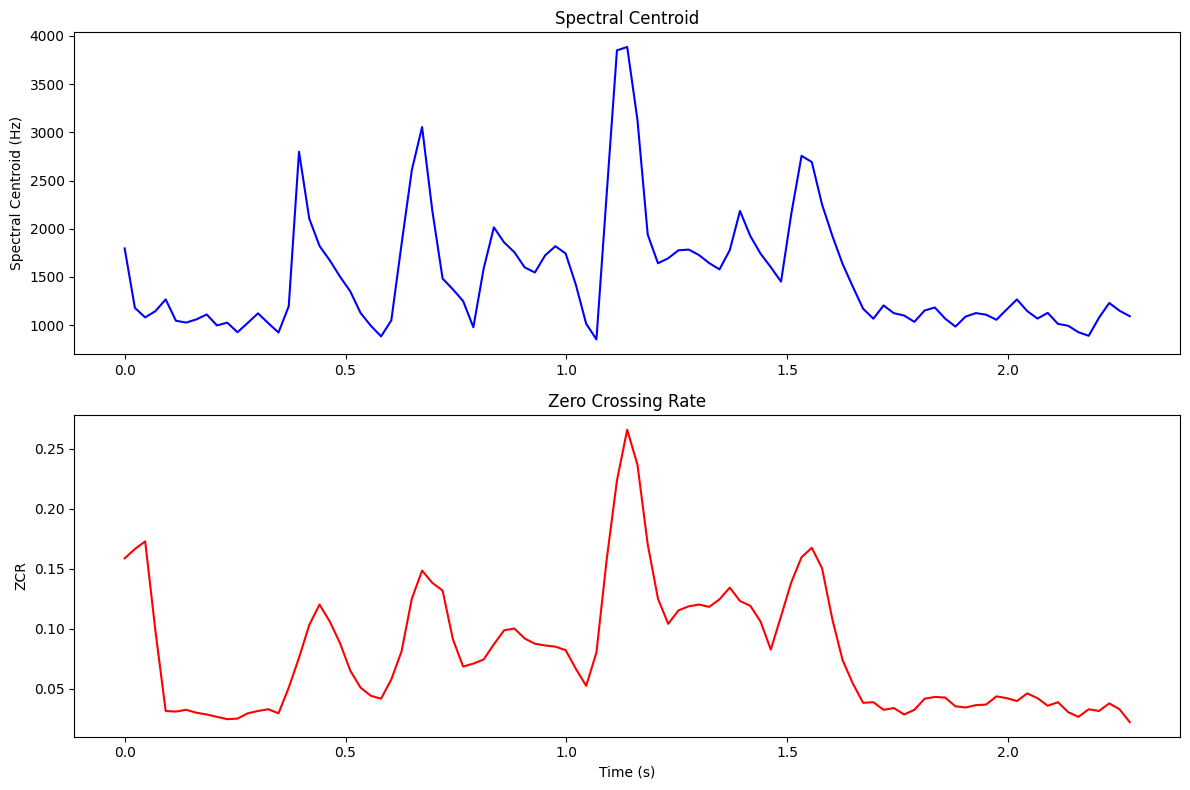

In [12]:
path = '../../dataset/AudioWAV/1001_DFA_ANG_XX.wav'
y, sr = librosa.load(path)

features = extract_acoustic_features(y, sr)
visualize_features(features, sr)

In [25]:
def aggregate_features(features):
    aggregated = {}
    
    aggregated['mfcc_mean'] = np.mean(features['mfcc'], axis=1).tolist()
    aggregated['mfcc_delta_mean'] = np.mean(features['mfcc_delta'], axis=1).tolist()
    aggregated['mfcc_delta2_mean'] = np.mean(features['mfcc_delta2'], axis=1).tolist()

    aggregated['mel_spec_db_mean'] = np.mean(features['mel_spec_db'], axis=1).tolist()

    aggregated['spectral_centroid_mean'] = np.mean(features['spectral_centroid'])

    aggregated['zcr_mean'] = np.mean(features['zcr'])
    
    return aggregated

In [40]:
mfcc_mean = []
mfcc_delta_mean = []
mfcc_delta2_mean = []
mel_spec_db_mean = []
spectral_centroid_mean = []
zcr_mean = []

for index, row in df.iterrows():
    y, sr = librosa.load(row['Location'])
    features = extract_acoustic_features(y, sr)
    aggregated_features = aggregate_features(features)
    mfcc_mean.append(aggregated_features['mfcc_mean'])
    mfcc_delta_mean.append(aggregated_features['mfcc_delta_mean'])
    mfcc_delta2_mean.append(aggregated_features['mfcc_delta2_mean'])
    mel_spec_db_mean.append(aggregated_features['mel_spec_db_mean'])
    spectral_centroid_mean.append(aggregated_features['spectral_centroid_mean'])
    zcr_mean.append(aggregated_features['zcr_mean'])

df['mfcc_mean'] = mfcc_mean
df['mfcc_delta_mean'] = mfcc_delta_mean
df['mfcc_delta2_mean'] = mfcc_delta2_mean
df['mel_spec_db_mean'] = mel_spec_db_mean
df['spectral_centroid_mean'] = spectral_centroid_mean
df['zcr_mean'] = zcr_mean

In [41]:
df

,Gender,Age,Emotion,Emotion levels,Location,mfcc_mean,mfcc_delta_mean,mfcc_delta2_mean,mel_spec_db_mean,spectral_centroid_mean,zcr_mean
0,Male,42,ANG,XX,../../dataset/AudioWAV/1041_IOM_ANG_XX.wav,"[-326.2571716308594, 131.7582550048828, 6.1154...","[0.1255483478307724, 0.0030219131149351597, -0...","[-0.06625314801931381, -0.06355936825275421, -...","[-40.790618896484375, -42.56074523925781, -41....",1179.349322,0.043249
1,Male,29,HAP,XX,../../dataset/AudioWAV/1005_ITH_HAP_XX.wav,"[-358.2459411621094, 127.40997314453125, -14.4...","[0.1006937250494957, -0.023168224841356277, -0...","[-0.014264722354710102, 0.020047934725880623, ...","[-51.56120300292969, -45.58784866333008, -39.5...",1500.493431,0.070299
2,Female,52,ANG,MD,../../dataset/AudioWAV/1056_IEO_ANG_MD.wav,"[-273.2405090332031, 88.28800201416016, -3.525...","[-0.021853862330317497, -0.05562637746334076, ...","[-0.07706470787525177, -0.09429140388965607, -...","[-52.3060188293457, -54.23222732543945, -52.04...",1761.658971,0.085656
3,Male,62,HAP,LO,../../dataset/AudioWAV/1087_IEO_HAP_LO.wav,"[-479.1881103515625, 135.39967346191406, 26.78...","[0.026304759085178375, -0.005736589431762695, ...","[-0.10344648361206055, -0.022910796105861664, ...","[-37.45167541503906, -26.1318359375, -22.67318...",1117.330547,0.036856
4,Female,33,ANG,XX,../../dataset/AudioWAV/1052_MTI_ANG_XX.wav,"[-252.0337371826172, 109.15762329101562, -4.00...","[0.05976373329758644, 0.057750023901462555, 0....","[-0.034133877605199814, -0.031858768314123154,...","[-47.52482223510742, -52.19740676879883, -50.6...",1439.093152,0.064631
...,...,...,...,...,...,...,...,...,...,...,...
7437,Female,20,FEA,XX,../../dataset/AudioWAV/1082_TAI_FEA_XX.wav,"[-376.8907165527344, 115.07537841796875, 6.563...","[0.0718960389494896, 0.059239327907562256, 0.0...","[-0.2090027928352356, -0.044961683452129364, 0...","[-45.30091094970703, -33.967140197753906, -32....",1733.797389,0.094620
7438,Female,21,NEU,XX,../../dataset/AudioWAV/1002_MTI_NEU_XX.wav,"[-441.2577209472656, 137.40689086914062, 1.919...","[0.007813234813511372, 0.0019433539127930999, ...","[-0.1413743793964386, -0.029882824048399925, 0...","[-42.70682907104492, -38.069862365722656, -32....",1312.391145,0.051037
7439,Male,45,ANG,LO,../../dataset/AudioWAV/1083_IEO_ANG_LO.wav,"[-338.41162109375, 114.89805603027344, -4.6734...","[0.934953510761261, -0.3876592814922333, -0.42...","[0.7294207811355591, -0.19926434755325317, -0....","[-46.6953010559082, -36.81074523925781, -31.55...",1825.146631,0.092624
7440,Male,32,NEU,XX,../../dataset/AudioWAV/1011_IOM_NEU_XX.wav,"[-421.2152404785156, 140.95579528808594, 10.92...","[0.11217541992664337, 0.05309046432375908, -0....","[0.01666495017707348, 0.003503540065139532, -0...","[-27.388154983520508, -29.533885955810547, -27...",1140.460215,0.037141


In [43]:
path = '../../dataset/'
path = os.path.join(path, 'features.csv')
df.to_csv(path, index=False)